In [209]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyspark
import pprint
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

import pickle

In [2]:
# Build a .py script that takes a snapshot date, trains a model and outputs artefact into storage.

## set up pyspark session

In [210]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

## set up config

In [211]:
# set up config
model_train_date_str = "2017-12-04" # "2024-09-01"
train_test_period_months = 12
oot_period_months = 3
train_test_ratio = 0.2

config = {}
config["model_train_date_str"] = model_train_date_str
config["train_test_period_months"] = train_test_period_months
config["oot_period_months"] =  oot_period_months
config["model_train_date"] =  datetime.strptime(model_train_date_str, "%Y-%m-%d")
config["oot_end_date"] =  config['model_train_date'] - timedelta(days = 1)
config["oot_start_date"] =  config['model_train_date'] - relativedelta(months = oot_period_months)
config["train_test_end_date"] =  config["oot_start_date"] - timedelta(days = 1)
config["train_test_start_date"] =  config["oot_start_date"] - relativedelta(months = train_test_period_months)
config["train_test_ratio"] = train_test_ratio 


pprint.pprint(config)

{'model_train_date': datetime.datetime(2017, 12, 4, 0, 0),
 'model_train_date_str': '2017-12-04',
 'oot_end_date': datetime.datetime(2017, 12, 3, 0, 0),
 'oot_period_months': 3,
 'oot_start_date': datetime.datetime(2017, 9, 4, 0, 0),
 'train_test_end_date': datetime.datetime(2017, 9, 3, 0, 0),
 'train_test_period_months': 12,
 'train_test_ratio': 0.2,
 'train_test_start_date': datetime.datetime(2016, 9, 4, 0, 0)}


## get data 

In [212]:
def read_gold_table(table, gold_db, spark):
    """
    Helper function to read all partitions of a gold table
    """
    folder_path = os.path.join(gold_db, table)
    files_list = [os.path.join(folder_path, os.path.basename(f)) for f in glob.glob(os.path.join(folder_path, '*'))]
    df = spark.read.option("header", "true").parquet(*files_list)
    return df


In [213]:
features_store_sdf = read_gold_table('feature_store', 'datamart/gold', spark)
label_store_sdf = read_gold_table('label_store', 'datamart/gold', spark)

## Data split

In [214]:
#Filter for delivered data for training 
features_store_sdf = features_store_sdf.drop("concentration","act_days_to_deliver","total_freight_value","avg_processing_time","same_state","total_volume_cm3")
rows_with_nulls = features_store_sdf.filter(
    reduce(lambda a, b: a | b, (col(c).isNull() for c in features_store_sdf.columns)))
order_ids_to_drop = [row["order_id"] for row in rows_with_nulls.select("order_id").distinct().collect()]

features_store_sdf = features_store_sdf.filter(~col("order_id").isin(order_ids_to_drop))
features_store_sdf = features_store_sdf.filter(col("order_status") == "delivered")
#features_store_sdf = features_store_sdf.filter(col("order_status") == "delivered")

#Filter for test and train data
label_store_sdf = label_store_sdf.filter(~col("order_id").isin(order_ids_to_drop))
y_model = label_store_sdf.filter((col("snapshot_date") >= config["train_test_start_date"]) & (col("snapshot_date") <= config["train_test_end_date"]))
y_model_oot = label_store_sdf.filter((col("snapshot_date") >= config["oot_start_date"]) & (col("snapshot_date") <= config["oot_end_date"]))

# Change to pandas for training 
features_store_sdf = features_store_sdf.toPandas().sort_values(by=["order_id"])
y_model = y_model.toPandas().sort_values(by=["order_id"])
X_model = features_store_sdf[np.isin(features_store_sdf['order_id'], y_model['order_id'].unique())]

# Change to pandas for OOT 
y_model_oot = y_model_oot.toPandas().sort_values(by=["order_id"])
X_model_oot = features_store_sdf[np.isin(features_store_sdf['order_id'], y_model_oot['order_id'].unique())]

print("Extract data for training and testing...")
print("extracted labels_sdf", y_model.shape[0])
print("extracted features_sdf", X_model.shape[0])

print("\n Extract data for oot...")
print("extracted labels_sdf", y_model_oot.shape[0])
print("extracted features_sdf", X_model_oot.shape[0])

Extract data for training and testing...
extracted labels_sdf 22523
extracted features_sdf 22523

 Extract data for oot...
extracted labels_sdf 15951
extracted features_sdf 15951


In [217]:
print(X_model.shape)
print(X_model_oot.shape)

print(y_model.shape)
print(y_model_oot.shape)

(22523, 15)
(15951, 15)
(22523, 3)
(15951, 3)


## Prepare data for training

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, 
                                                    test_size=config['train_test_ratio'], 
                                                    random_state=42, 
                                                    shuffle=True, 
                                                    stratify=y_model['miss_delivery_sla'])

In [219]:
print(X_train.shape)
print(X_test.shape)
print(X_model_oot.shape)

(18018, 15)
(4505, 15)
(15951, 15)


In [220]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 1. Fit on X_train
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[['season']])  # Only fit on training data

# 2. Transform train
encoded_train = encoder.transform(X_train[['season']])
encoded_df_train = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(['season']), index=X_train.index)
X_train = pd.concat([X_train.drop(columns=['season']), encoded_df_train], axis=1)

# 3. Transform test
encoded_test = encoder.transform(X_test[['season']])
encoded_df_test = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(['season']), index=X_test.index)
X_test = pd.concat([X_test.drop(columns=['season']), encoded_df_test], axis=1)

# 4. Transform OOT
encoded_oot = encoder.transform(X_model_oot[['season']])
encoded_df_oot = pd.DataFrame(encoded_oot, columns=encoder.get_feature_names_out(['season']), index=X_model_oot.index)
X_model_oot = pd.concat([X_model_oot.drop(columns=['season']), encoded_df_oot], axis=1)

In [221]:
print(X_train.shape)
print(X_test.shape)
print(X_model_oot.shape)

(18018, 18)
(4505, 18)
(15951, 18)


In [172]:
X_train_numeric.columns

Index(['total_qty', 'total_price', 'total_weight_g', 'total_volume_cm3',
       'total_density', 'delivery_distance', 'same_city', 'same_state',
       'is_weekend', 'avg_rating', 'avg_delay_rate', 'avg_processing_time',
       'day_of_week', 'season_Autumn', 'season_Spring', 'season_Summer',
       'season_Winter'],
      dtype='object')

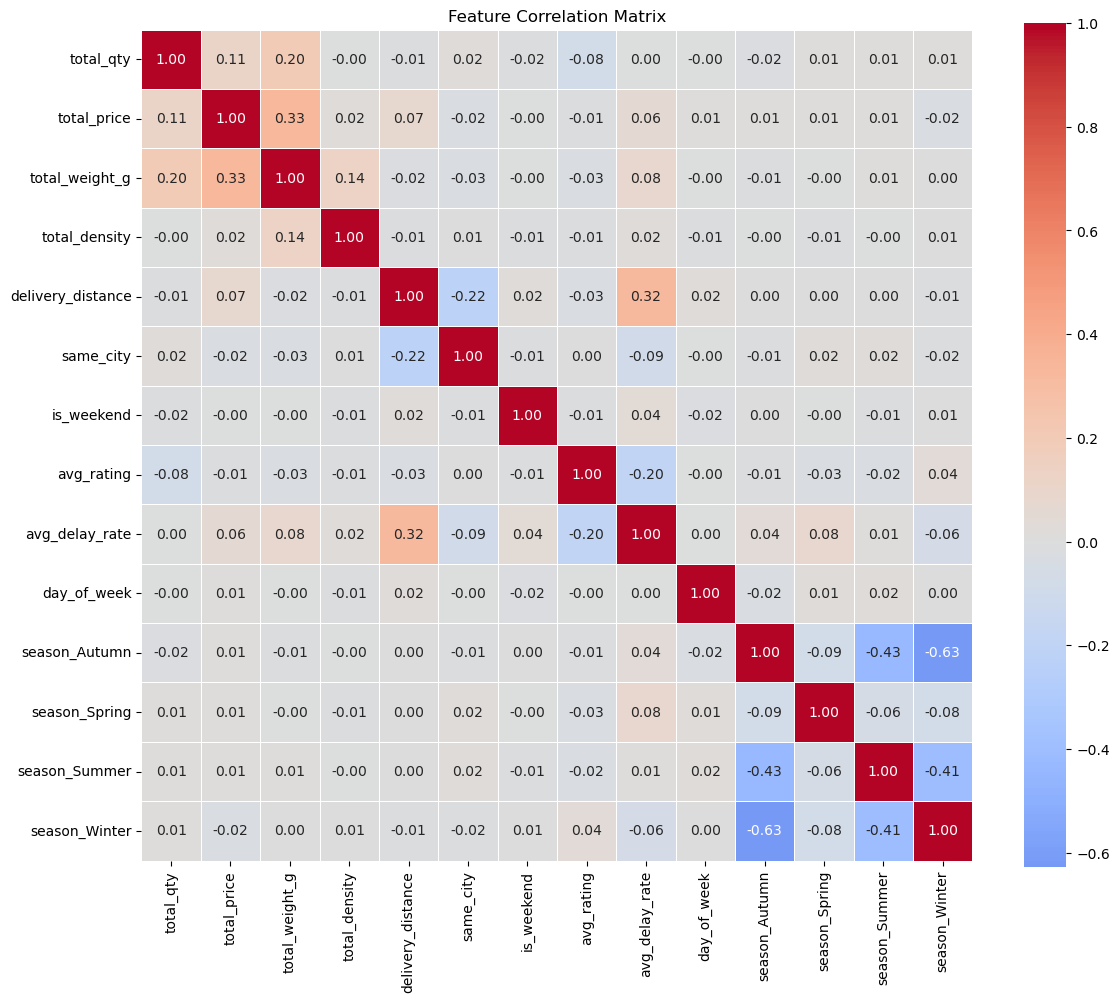

In [222]:
X_train_numeric = X_train.select_dtypes(include='number')
X_train_numeric.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(
    X_train_numeric.corr(),
    annot=True,       # Show correlation values
    fmt=".2f",         # Format to 2 decimal places
    cmap="coolwarm",   # Color gradient: red to blue
    center=0,          # Center color at 0 correlation
    square=True,
    linewidths=0.5
)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [223]:
# Transform data into numpy arrays
X_train_arr = X_train.drop(columns=['order_id','order_status','seller_city','seller_state']).values
X_test_arr = X_test.drop(columns=['order_id','order_status','seller_city','seller_state']).values
X_oot_arr = X_model_oot.drop(columns=['order_id','order_status','seller_city','seller_state']).values

y_train = y_train['miss_delivery_sla'].values
y_test = y_test['miss_delivery_sla'].values
y_oot = y_model_oot['miss_delivery_sla'].values

# Normalize the data using sklearn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
transformer_stdscaler = scaler.fit(X_train_arr)

X_train_processed = transformer_stdscaler.transform(X_train_arr)
X_test_processed = transformer_stdscaler.transform(X_test_arr)
X_oot_processed = transformer_stdscaler.transform(X_oot_arr)

# Print diagnostics
print('X_train_processed', X_train_processed.shape[0])
print('X_test_processed', X_test_processed.shape[0])
print('X_oot_processed', X_oot_processed.shape[0])
print("X_train shape:", X_train_arr.shape)

X_train_processed 18018
X_test_processed 4505
X_oot_processed 15951
X_train shape: (18018, 14)


In [224]:
transformer_stdscaler.n_features_in_ 

14

In [195]:
X_features = X_train.drop(columns=['order_id','order_status','seller_city','seller_state'])

X_features

,total_qty,total_price,total_weight_g,total_density,delivery_distance,same_city,is_weekend,avg_rating,avg_delay_rate,day_of_week,season_Autumn,season_Spring,season_Summer,season_Winter
19899,1,25.50,537.0,0.088790,448.158991,0,0,5.000000,0.000000,5,1.0,0.0,0.0,0.0
13351,1,59.90,1550.0,0.078283,406.989026,0,0,4.500000,0.500000,2,0.0,0.0,0.0,1.0
33696,1,149.90,1200.0,0.120000,28.135558,1,0,1.000000,1.000000,6,1.0,0.0,0.0,0.0
37287,1,453.70,2100.0,0.300000,465.813692,0,0,5.000000,0.000000,5,0.0,0.0,1.0,0.0
20476,1,99.90,1175.0,0.078543,1924.369230,0,0,4.000000,1.000000,6,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33917,1,39.99,1050.0,0.168000,578.457995,0,1,4.500000,0.500000,7,1.0,0.0,0.0,0.0
37933,2,139.80,1900.0,0.040212,707.279001,0,0,4.333333,1.000000,2,0.0,0.0,1.0,0.0
34265,2,31.80,2000.0,0.081633,338.759632,0,0,3.000000,0.000000,6,0.0,0.0,1.0,0.0
31774,1,109.99,5950.0,0.743750,439.123698,0,1,5.000000,0.000000,1,1.0,0.0,0.0,0.0


In [ ]:
print(len(X_train_processed.columns))     # e.g. 25
print(len(importances))         # e.g. 19

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

## Train the model

In [225]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Define fixed hyperparameters
params = {
    'n_estimators': 300,
    'max_depth': 3,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'min_child_weight': 3,
    'reg_alpha': 3,
    'reg_lambda': 1
}

# Train model
model = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    **params
)

model.fit(X_train_processed, y_train)

# Predict and evaluate
y_pred_train = model.predict_proba(X_train_processed)[:, 1]
y_pred_test = model.predict_proba(X_test_processed)[:, 1]
y_pred_oot = model.predict_proba(X_oot_processed)[:, 1]

train_auc = roc_auc_score(y_train, y_pred_train)
test_auc = roc_auc_score(y_test, y_pred_test)
oot_auc = roc_auc_score(y_oot, y_pred_oot)

print("\n=== MODEL EVALUATION ===")
print("Train AUC:", round(train_auc, 4), "| GINI:", round(2*train_auc - 1, 4))
print("Test AUC :", round(test_auc, 4), "| GINI:", round(2*test_auc - 1, 4))
print("OOT AUC  :", round(oot_auc, 4), "| GINI:", round(2*oot_auc - 1, 4))


=== MODEL EVALUATION ===
Train AUC: 0.945 | GINI: 0.8901
Test AUC : 0.9491 | GINI: 0.8981
OOT AUC  : 0.943 | GINI: 0.886


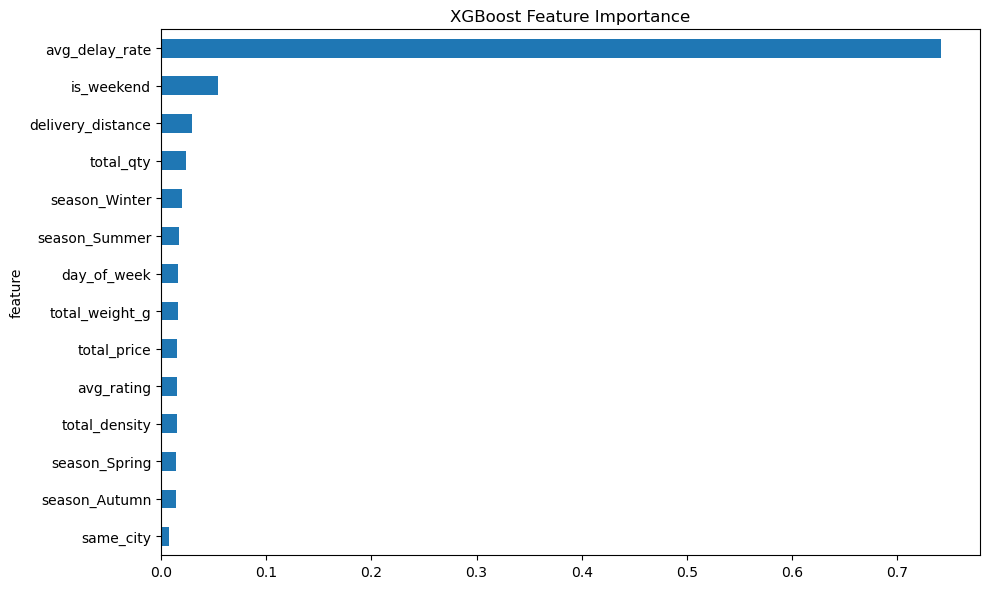

In [226]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# After training
model = XGBClassifier()
model.fit(X_train_processed, y_train)

# Get importance as a dictionary
importances = model.feature_importances_

# Create a DataFrame for easy visualization
import pandas as pd
feat_importance_df = pd.DataFrame({
    'feature': X_features.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot
feat_importance_df.plot(kind='barh', x='feature', y='importance', figsize=(10, 6), legend=False)
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

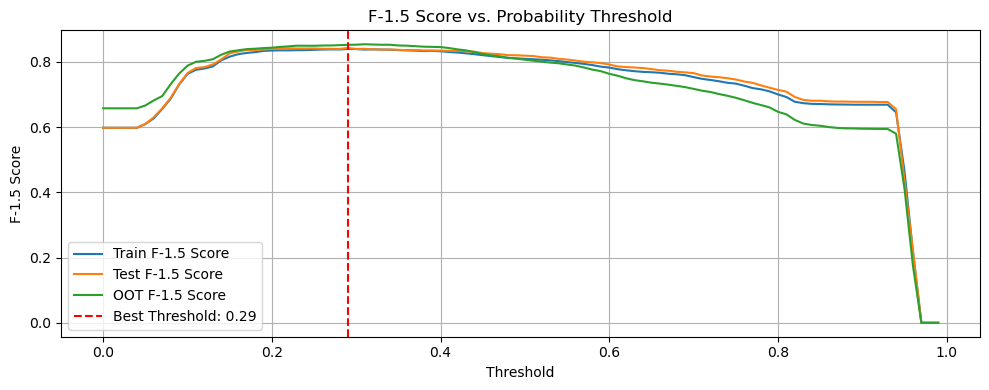

In [227]:
# F1.5 score across thresholds - recall is more important
thresholds = np.arange(0.0, 1.0, 0.01)
beta = 1.5
f1_scores_train = [fbeta_score(y_train, y_pred_train > t, beta=beta) for t in thresholds]
f1_scores_test = [fbeta_score(y_test, y_pred_test > t, beta=beta) for t in thresholds]
f1_scores_oot = [fbeta_score(y_oot, y_pred_oot > t, beta=beta) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores_train)]

# Plot F1 Score vs. Threshold
plt.figure(figsize=(10, 4))
plt.plot(thresholds, f1_scores_train, label="Train F-%.1f Score" % beta)
plt.plot(thresholds, f1_scores_test, label="Test F-%.1f Score" % beta)
plt.plot(thresholds, f1_scores_oot, label="OOT F-%.1f Score" % beta)
plt.axvline(x=best_threshold, color="red", linestyle="--", label="Best Threshold: %.2f" % round(best_threshold, 2))
plt.title("F-%.1f Score vs. Probability Threshold" % beta)
plt.xlabel("Threshold")
plt.ylabel("F-%.1f Score" % beta)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

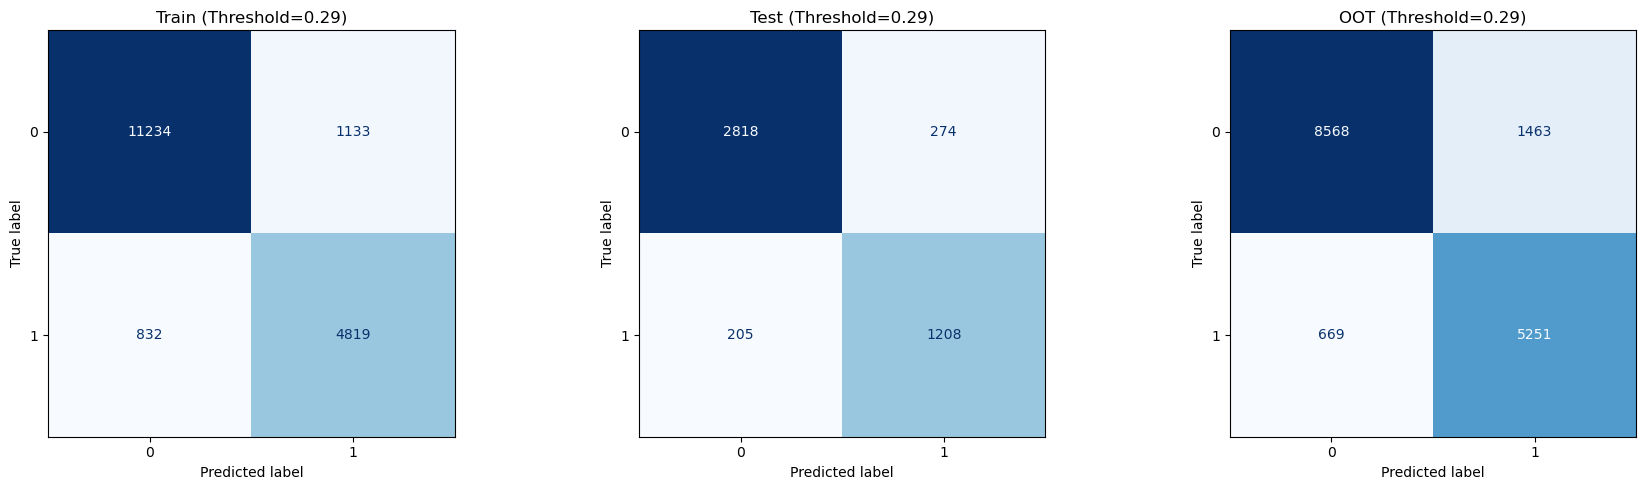

In [228]:
# Predictions
y_pred_train = (y_pred_train > best_threshold).astype(int)
y_pred_test = (y_pred_test > best_threshold).astype(int)
y_pred_oot = (y_pred_oot > best_threshold).astype(int)

# Confusion matrices
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)
cm_oot = confusion_matrix(y_oot, y_pred_oot)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Train
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(ax=axs[0], cmap='Blues', colorbar=False)
axs[0].set_title(f"Train (Threshold={best_threshold:.2f})")
axs[0].grid(False)

# Test
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(ax=axs[1], cmap='Blues', colorbar=False)
axs[1].set_title(f"Test (Threshold={best_threshold:.2f})")
axs[1].grid(False)

# OOT
disp_oot = ConfusionMatrixDisplay(confusion_matrix=cm_oot)
disp_oot.plot(ax=axs[2], cmap='Blues', colorbar=False)
axs[2].set_title(f"OOT (Threshold={best_threshold:.2f})")
axs[2].grid(False)

plt.tight_layout()
plt.show()

In [229]:
# Set beta
beta = 1.5

# Compute F1.5 scores
f1_5_train = fbeta_score(y_train, y_pred_train, beta=beta)
f1_5_test = fbeta_score(y_test, y_pred_test, beta=beta)
f1_5_oot = fbeta_score(y_oot, y_pred_oot, beta=beta)

# Print results
print("\n=== MODEL F1.5 SCORE ===")
print(f"Train F1.5 Score : {f1_5_train:.4f}")
print(f"Test F1.5 Score  : {f1_5_test:.4f}")
print(f"OOT F1.5 Score   : {f1_5_oot:.4f}")


=== MODEL F1.5 SCORE ===
Train F1.5 Score : 0.8390
Test F1.5 Score  : 0.8423
OOT F1.5 Score   : 0.8518


#### Logistic regression

In [230]:
# Train model
clf = LogisticRegression()
clf.fit(X_train_processed, y_train)

# Predict and evaluate
y_pred_proba_train = clf.predict_proba(X_train_processed)[:, 1]
train_auc = roc_auc_score(y_train, y_pred_proba_train)

y_pred_proba_test = clf.predict_proba(X_test_processed)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba_test)

y_pred_proba_oot = clf.predict_proba(X_oot_processed)[:, 1]
oot_auc = roc_auc_score(y_oot, y_pred_proba_oot)

print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"OOT AUC: {oot_auc:.4f}")

Train AUC: 0.9418
Test AUC: 0.9466
OOT AUC: 0.9397


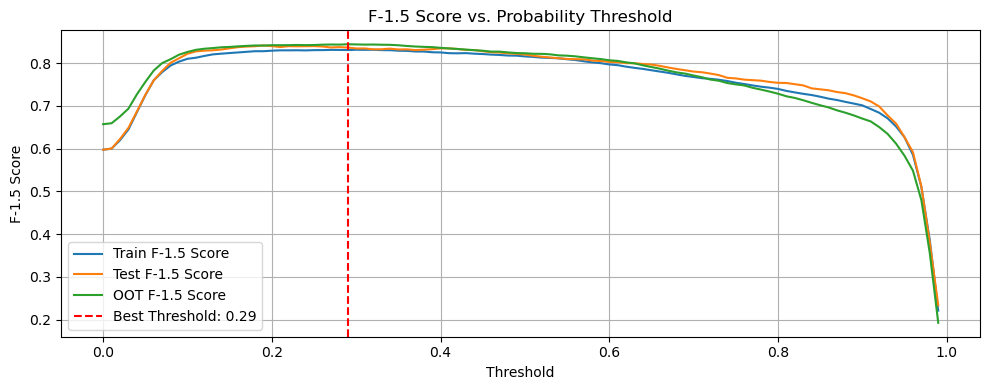

In [231]:
# F2 score across thresholds
thresholds = np.arange(0.0, 1.0, 0.01)
beta = 1.5
f1_scores_train = [fbeta_score(y_train, y_pred_proba_train > t, beta=beta) for t in thresholds]
f1_scores_test = [fbeta_score(y_test, y_pred_proba_test > t, beta=beta) for t in thresholds]
f1_scores_oot = [fbeta_score(y_oot, y_pred_proba_oot > t, beta=beta) for t in thresholds]
best_threshold_reg = thresholds[np.argmax(f1_scores_train)]

# Plot F1 Score vs. Threshold
plt.figure(figsize=(10, 4))
plt.plot(thresholds, f1_scores_train, label=f"Train F-{beta} Score")
plt.plot(thresholds, f1_scores_test, label=f"Test F-{beta} Score")
plt.plot(thresholds, f1_scores_oot, label=f"OOT F-{beta} Score")
plt.axvline(x=best_threshold, color="red", linestyle="--", label=f"Best Threshold: {best_threshold:.2f}")
plt.title(f"F-{beta} Score vs. Probability Threshold")
plt.xlabel("Threshold")
plt.ylabel(f"F-{beta} Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [232]:
print(f"Best Train F{beta}-Score: {max(f1_scores_train):.4f}")
print(f"Best Test F{beta}-Score: {max(f1_scores_test):.4f}")
print(f"Best OOT F{beta}-Score: {max(f1_scores_oot):.4f}")

Best Train F1.5-Score: 0.8315
Best Test F1.5-Score: 0.8417
Best OOT F1.5-Score: 0.8444


In [233]:
model_artefact_reg = {}

model_artefact_reg['model'] = clf
model_artefact_reg['hp_params'] = clf.get_params()
model_artefact_reg['model_version'] = "reg_"+config["model_train_date_str"].replace('-','_')
model_artefact_reg['preprocessing_transformers'] = {}
model_artefact_reg['preprocessing_transformers']['stdscaler'] = transformer_stdscaler
model_artefact_reg['data_dates'] = config
model_artefact_reg['data_stats'] = {}
model_artefact_reg['data_stats']['X_train'] = X_train_arr.shape[0]
model_artefact_reg['data_stats']['X_test'] = X_test_arr.shape[0]
model_artefact_reg['data_stats']['X_oot'] = X_oot_arr.shape[0]
model_artefact_reg['data_stats']['y_train'] = round(y_train.mean(),2)
model_artefact_reg['data_stats']['y_test'] = round(y_test.mean(),2)
model_artefact_reg['data_stats']['y_oot'] = round(y_oot.mean(),2)
model_artefact_reg['results'] = {}
model_artefact_reg['results']['f1_train'] = max(f1_scores_train)
model_artefact_reg['results']['f1_test'] =  max(f1_scores_test)
model_artefact_reg['results']['f1_oot'] =  max(f1_scores_oot)
model_artefact_reg['threshold'] = best_threshold_reg

pprint.pprint(model_artefact_reg)

{'data_dates': {'model_train_date': datetime.datetime(2017, 12, 4, 0, 0),
                'model_train_date_str': '2017-12-04',
                'oot_end_date': datetime.datetime(2017, 12, 3, 0, 0),
                'oot_period_months': 3,
                'oot_start_date': datetime.datetime(2017, 9, 4, 0, 0),
                'train_test_end_date': datetime.datetime(2017, 9, 3, 0, 0),
                'train_test_period_months': 12,
                'train_test_ratio': 0.2,
                'train_test_start_date': datetime.datetime(2016, 9, 4, 0, 0)},
 'data_stats': {'X_oot': 15951,
                'X_test': 4505,
                'X_train': 18018,
                'y_oot': 0.37,
                'y_test': 0.31,
                'y_train': 0.31},
 'hp_params': {'C': 1.0,
               'class_weight': None,
               'dual': False,
               'fit_intercept': True,
               'intercept_scaling': 1,
               'l1_ratio': None,
               'max_iter': 100,
               'mu

## prepare model artefact to save

In [234]:
model_artefact_xgb = {}

model_artefact_xgb['model'] = model
model_artefact_xgb['hp_params'] = params
model_artefact_xgb['model_version'] = "xgb_"+config["model_train_date_str"].replace('-','_')
model_artefact_xgb['preprocessing_transformers'] = {}
model_artefact_xgb['preprocessing_transformers']['stdscaler'] = transformer_stdscaler
model_artefact_xgb['data_dates'] = config
model_artefact_xgb['data_stats'] = {}
model_artefact_xgb['data_stats']['X_train'] = X_train_arr.shape[0]
model_artefact_xgb['data_stats']['X_test'] = X_test_arr.shape[0]
model_artefact_xgb['data_stats']['X_oot'] = X_oot_arr.shape[0]
model_artefact_xgb['data_stats']['y_train'] = round(y_train.mean(),2)
model_artefact_xgb['data_stats']['y_test'] = round(y_test.mean(),2)
model_artefact_xgb['data_stats']['y_oot'] = round(y_oot.mean(),2)
model_artefact_xgb['results'] = {}
model_artefact_xgb['results']['auc_train'] = train_auc
model_artefact_xgb['results']['auc_test'] = test_auc
model_artefact_xgb['results']['auc_oot'] = oot_auc
model_artefact_xgb['results']['gini_train'] = round(2*train_auc-1,3)
model_artefact_xgb['results']['gini_test'] = round(2*test_auc-1,3)
model_artefact_xgb['results']['gini_oot'] = round(2*oot_auc-1,3)
model_artefact_xgb['results']['f1_train'] = f1_5_train
model_artefact_xgb['results']['f1_test'] = f1_5_test
model_artefact_xgb['results']['f1_oot'] = f1_5_oot
model_artefact_xgb['threshold'] = best_threshold

pprint.pprint(model_artefact_xgb)

{'data_dates': {'model_train_date': datetime.datetime(2017, 12, 4, 0, 0),
                'model_train_date_str': '2017-12-04',
                'oot_end_date': datetime.datetime(2017, 12, 3, 0, 0),
                'oot_period_months': 3,
                'oot_start_date': datetime.datetime(2017, 9, 4, 0, 0),
                'train_test_end_date': datetime.datetime(2017, 9, 3, 0, 0),
                'train_test_period_months': 12,
                'train_test_ratio': 0.2,
                'train_test_start_date': datetime.datetime(2016, 9, 4, 0, 0)},
 'data_stats': {'X_oot': 15951,
                'X_test': 4505,
                'X_train': 18018,
                'y_oot': 0.37,
                'y_test': 0.31,
                'y_train': 0.31},
 'hp_params': {'colsample_bytree': 0.8,
               'gamma': 0,
               'learning_rate': 0.01,
               'max_depth': 3,
               'min_child_weight': 3,
               'n_estimators': 300,
               'reg_alpha': 3,
           

## save artefact to model bank

In [235]:
import os
os.getcwd()

'/Users/baohongzhuang/Desktop/03 MLE/MLE_grp10/scripts'

In [236]:
# create model_bank dir
model_bank_directory = "model_bank/"

if not os.path.exists(model_bank_directory):
    os.makedirs(model_bank_directory)

In [237]:
# Full path to the file
file_path = os.path.join(model_bank_directory, model_artefact_reg['model_version'] + '.pkl')

# Write the model to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(model_artefact_reg, file)

print(f"Model saved to {file_path}")

Model saved to model_bank/reg_2017_12_04.pkl


In [238]:
# Full path to the file
file_path = os.path.join(model_bank_directory, model_artefact_xgb['model_version'] + '.pkl')

# Write the model to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(model_artefact_xgb, file)

print(f"Model saved to {file_path}")


Model saved to model_bank/xgb_2017_12_04.pkl


## test load pickle and make model inference

In [ ]:
# Load the model from the pickle file
with open(file_path, 'rb') as file:
    loaded_model_artefact = pickle.load(file)

y_pred_proba = loaded_model_artefact['model'].predict_proba(X_oot_processed)[:, 1]
oot_auc_score = roc_auc_score(y_oot, y_pred_proba)
print("OOT AUC score: ", oot_auc_score)

print("Model loaded successfully!")

OOT AUC score:  0.7084856781951092
Model loaded successfully!


25/06/20 10:59:51 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE